## XYZ_Hamiltonian_model

In [1]:
import os
from torch import nn
from modules import utils
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
import torch
import torch.multiprocessing as mp
from modules.utils import CONFIG_PATH
from modules.data_loader import StaticDataset,DynamicDataset
from torch.utils.data import DataLoader
from modules.models import BPNet, RNN_50_100
import numpy as np
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pylab as plt
assert torch.cuda.is_available(), "CPU training is not allowed."
hps = utils.get_hparams(config_path="XYZ_config.json")
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = hps.train.port
n_gpus = torch.cuda.device_count()
dist.init_process_group(backend= 'gloo' if os.name == 'nt' else 'nccl', init_method='env://', world_size=n_gpus, rank=0)

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.


In [2]:
def draw_heatmap(loss_matrix,xLabel,yLabel):
    fig = plt.figure()
    # 定义画布为1*1个划分，并在第1个位置上进行作图
    ax = fig.add_subplot(111)
    # 定义横纵坐标的刻度
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    # 作图并选择热图的颜色填充风格，这里选择hot
    minxs = []
    minys = []
    minit = None
    counter = 0
    for col in loss_matrix.T:
        tempcol = list(col)[::-1]
        for it in tempcol:
            if it <= 0.01:
                minit = len(tempcol) - tempcol.index(it) - 1
                break
        minxs.append(counter)
        minys.append(minit)
        counter+=1
    plt.plot(minxs,minys)
    plt.scatter(minxs,minys)
    im = ax.imshow(loss_matrix, cmap=plt.cm.hot_r,vmin=0)#)
    # 增加右侧的颜色刻度条
    plt.colorbar(im)
    # 增加标题
    #plt.title("This is a title", fontproperties=font)
    # show
    plt.show()

def infer(test_loader,hps):
    model = torch.load(hps.infer.model_dir)  # 读取模型
    model = DDP(model, device_ids=[0], find_unused_parameters=True)
    model.eval()
    inputs, outputs, infers = None, None, None
    for batch_idx, items in enumerate(test_loader):
        input_data, output_data = items
        input_data = input_data.cuda(0, non_blocking=True)
        output_data = output_data.cuda(0, non_blocking=True)
        if batch_idx == 0:
            infers = model(input_data)
            inputs = input_data
            outputs = output_data
        else:
            infers = torch.cat([infers, model(input_data)], dim=0)
            inputs = torch.cat([inputs, input_data], dim=0)
            outputs = torch.cat([outputs, output_data], dim=0)
    lossfunc = nn.L1Loss()
    loss = lossfunc(infers,outputs).item()
    return loss

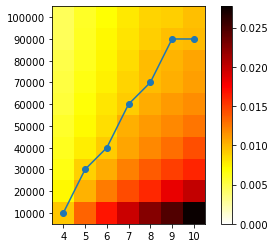

In [3]:
col_label = ['4','5','6','7','8','9','10']
row_label = [str(i) for i in range(10000,100001,10000)]
row_label = row_label[::-1]
loss_matrix = np.zeros([len(row_label),len(col_label)])
num_workers = 5 if mp.cpu_count() > 4 else mp.cpu_count()
for qubit in col_label:
    i = col_label.index(qubit)
    hps.data.test_dataset_path = "../../datasets/json/static/training_as_4_10qubits/XYZ_Hamiltonian_model/%squbit/test"%qubit
    test_dataset = StaticDataset(hps, "test") if hps.data.type == "static" else DynamicDataset(hps,"test")
    test_loader = DataLoader(test_dataset, num_workers=num_workers, shuffle=False, pin_memory=True,
                             batch_size=hps.infer.batch_size)
    for num_train in row_label:
        hps.infer.model_dir = "../../weights/training_as_4_10qubits/XYZ Hamiltonian model/%sbit_%s.pth"%(qubit,num_train)
        j = row_label.index(num_train)
        loss_matrix[j,i] = infer(test_loader,hps)
draw_heatmap(loss_matrix,col_label,row_label)